<center>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/imperial.png" width="250" vspace="8"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/mlgh.png" width="220" hspace="50" vspace="5"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/ammi.png" width="190"/>

<font size="6">Modern Statistics and Machine Learning<br> for Population Health in Africa </font>

<font size="4">24th - 28th March 2025</font>

</center>

<a href="https://colab.research.google.com/github/MLGlobalHealth/StatML4PopHealth/blob/main/assessments/groupwork_instruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Phylogenetics: Practical
### AIMS-Imperial: Modern Statistics for Global Health
**Author**: Dr Alexandra Blenkinsop

**Objective**: This practical will demonstrate a phylogenetic analysis pipeline from consensus sequences. Steps include creating an alignment, rooting with an outgroup, inferring a phylogeny using distance-based methods (neighbor-joining) and maximum-likelihood approaches, resolving alignment issues, and using bootstrapping to quantify uncertainty.



### Load Required Packages

In [ ]:
# Install required packages (run this once)
!pip install biopython ete3 scikit-bio seaborn matplotlib PyQt5 SciencePlots phytreeviz charset_normalizer

!pip install -q condacolab
import condacolab
condacolab.install()

!conda install -c bioconda raxml-ng modeltest-ng --yes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 78.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 113.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 124.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 130.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✨🍰✨ Everything looks OK!
Channels:
 - bioconda
 - conda-forge
Platform: linux-64
Solving environment: - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [7]:
from pathlib import Path
from Bio import SeqIO, Phylo
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceCalculator
from Bio.Phylo.Consensus import *
from Bio.Phylo import write as phylo_write, draw
from ete3 import Tree, TextFace
from ete3.treeview.main import TreeStyle, NodeStyle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
from skbio import DistanceMatrix
from skbio.tree import nj
import re
from phytreeviz import TreeViz
import os
import io
import subprocess
from Bio.Phylo.Applications import RaxmlCommandline
from scipy.stats import chi2

#from Bio.Phylo.Consensus import bootstrap_trees, bootstrap_consensus, majority_consensus


# Aesthetics
sns.set_theme(style="whitegrid")
font = {"family": "sans-serif",
        "weight": "normal",
		"size": 10.5}

In [ ]:
# create directory for outputs
#out_dir = './figures'
#os.makedirs(out_dir, exist_ok=True)  # Creates the folder if it doesn't exist

In [8]:
from google.colab import drive
drive.mount('/content/drive')

# Adjust this as required - this is where your output will be stored.
output_dir = Path(*["drive", "MyDrive", "StatML4PopHealth", "practical6","hiv"])
output_dir.mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data
The dataset for this practical lab contains partial *pol* consensus sequences from HIV-positive individuals from the Democratic Republic of Congo from a study by Faria et al (2019) tracing the evolutionary dynamics of major HIV-1 subtypes across Central and Eastern Africa. The data were obtained from the Los Alamos HIV sequence database, by searching for the GenBank Accession numbers listed in the manuscript and selecting a subset of subtypes for the purpose of this practical.

Download the data from github.com/MLGlobalHealth/StatML4PopHealth, which contain a subset of sequences from the study.

**Instructions:**
1. Download the `.fasta` file and place it in the working directory.
2. You can use alignment viewers like [AliView](https://ormbunkar.se/aliview/) or [Jalview](https://www.jalview.org/) to examine the sequences.

### Read in the alignment

Your first task is to load the multiple sequence alignment and have a look at its structure.

Read in the .fasta file. Note the format of FASTA - chevron denotes the taxon name. Gaps ‘-’ are indel events (insertions/deletions). ‘N’ represents unknown characters.

How many sequences are there and how long are they? Are they all the same length?

In [12]:
# load the input data
!curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/day5/practical6/data/hiv.fasta"

sequences = list(SeqIO.parse("hiv.fasta", "fasta"))

# summarise sequences
print(f"Number of sequences: {len(sequences)}")

shortest_seq = min(sequences, key=lambda seq: len(seq.seq))
longest_seq = max(sequences, key=lambda seq: len(seq.seq))

print(f"- Shortest sequence: {shortest_seq.id} | Length: {len(shortest_seq.seq)}")
print(f"- Longest sequence: {longest_seq.id} | Length: {len(longest_seq.seq)}")

# print first entry
record = sequences[0]
print(record)
print("ID:", record.id)
print("Description:", record.description)
print("Sequence type:", type(record.seq))
print("Sequence data:", record.seq)

curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60949  100 60949    0     0   865k      0 --:--:-- --:--:-- --:--:--  875k
Number of sequences: 55
- Shortest sequence: G.CD.2008.DRC319.MN178973 | Length: 1080
- Longest sequence: G.CD.2008.DRC319.MN178973 | Length: 1080
ID: G.CD.2008.DRC319.MN178973
Name: G.CD.2008.DRC319.MN178973
Description: G.CD.2008.DRC319.MN178973
Number of features: 0
Seq('CCCTTAGCCTCCCTCAAATCACTCTTTGGCAGCGACCCTTAGTCACTGTAAGAA...TAA')
ID: G.CD.2008.DRC319.MN178973
Description: G.CD.2008.DRC319.MN178973
Sequence type: <class 'Bio.Seq.Seq'>
Sequence data: CCCTTAGCCTCCCTCAAATCACTCTTTGGCAGCGACCCTTAGTCACTGTAAGAATAGGGGGACAGCTAATAGAAGCCCTATTAGACACAGGRGCAGATGATACAGTATTAGAAGATATAGATTTACCAGGAAAATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCARATACTTATRGAAATTTGTGGAAA

### Visualizing Sequence Data
Let's visualize the alignment, recoding ambiguous bases as 'others'. The x-axis is the position in the alignment, but this is not meaningful unless it is mapped to some known genomic coordinates. The y-axis are the taxa. We show the first 30 taxa only.


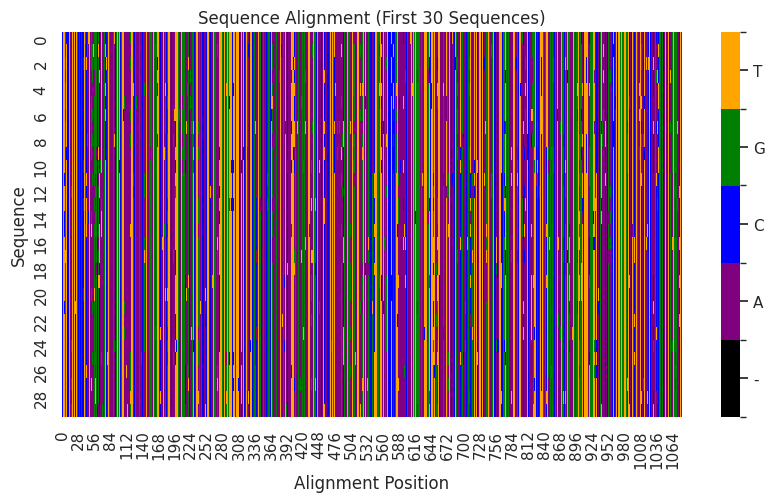

In [13]:
# make a mapping for nucleotide bases
nucleotide_mapping = {'A': 1, 'C': 2, 'G': 3, 'T': 4, '-': 0}
reverse_mapping = {v: k for k, v in nucleotide_mapping.items()}  # Reverse mapping for legend
reverse_mapping[5] = 'Other'  # Assign label for unknown bases

# convert sequences to a matrix of nucleotide characters
alignment_array = np.array([list(str(seq.seq)) for seq in sequences[:30]])

# xonvert nucleotides to numbers using the mapping
alignment_numeric = np.array([
    [nucleotide_mapping.get(nt, 5) for nt in str(seq.seq)]  # Map unknown bases to 5
    for seq in sequences[:30]
])

# convert to DataFrame
alignment_df = pd.DataFrame(alignment_numeric)

# define a discrete colormap
colors = ["black", "purple", "blue", "green", "yellow","orange"]  # Colors for bases
cmap = mcolors.ListedColormap(colors[:len(nucleotide_mapping) + 1])  # Ensure enough colors
bounds = sorted(list(nucleotide_mapping.values()) + [max(nucleotide_mapping.values()) + 1])  # Sorted bins
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Ensure bins are correctly ordered

# plot alignment as a heatmap
plt.figure(figsize=(10, 5))
ax = sns.heatmap(alignment_df, cbar=True, cmap=cmap, norm=norm)

# formatting
colorbar = ax.collections[0].colorbar
tick_positions = np.array(bounds[:-1]) + 0.5
colorbar.set_ticks(tick_positions)
colorbar.set_ticklabels([reverse_mapping.get(i, "Other") for i in bounds[:-1]])

plt.title("Sequence Alignment (First 30 Sequences)")
plt.xlabel("Alignment Position")
plt.ylabel("Sequence")
plt.show()


### Generating a Genetic Distance Matrix

Generate the pairwise distance matrix, assuming the Tamura and Nei model for the evolutionary rate, which has two parameters allowing for different base frequencies and different transition and substitution rates. This function generates a matrix of pairwise distances between taxa. Visualise the resulting matrix.

Note that entries 𝑖=𝑗 have a genetic distance of zero.

There are two types of HIV, HIV-1 and HIV-2, which can further be classified by subtype. All the sequences in this study are from individuals with HIV-1, which is the most prevalent type of HIV globally. The taxa labels indicate subtype. Subtypes are an indication of virus similarity. Which sequences have the smallest distances?

We find that sequences of the same subtype typically have smaller genetic distances than those of different subtypes.

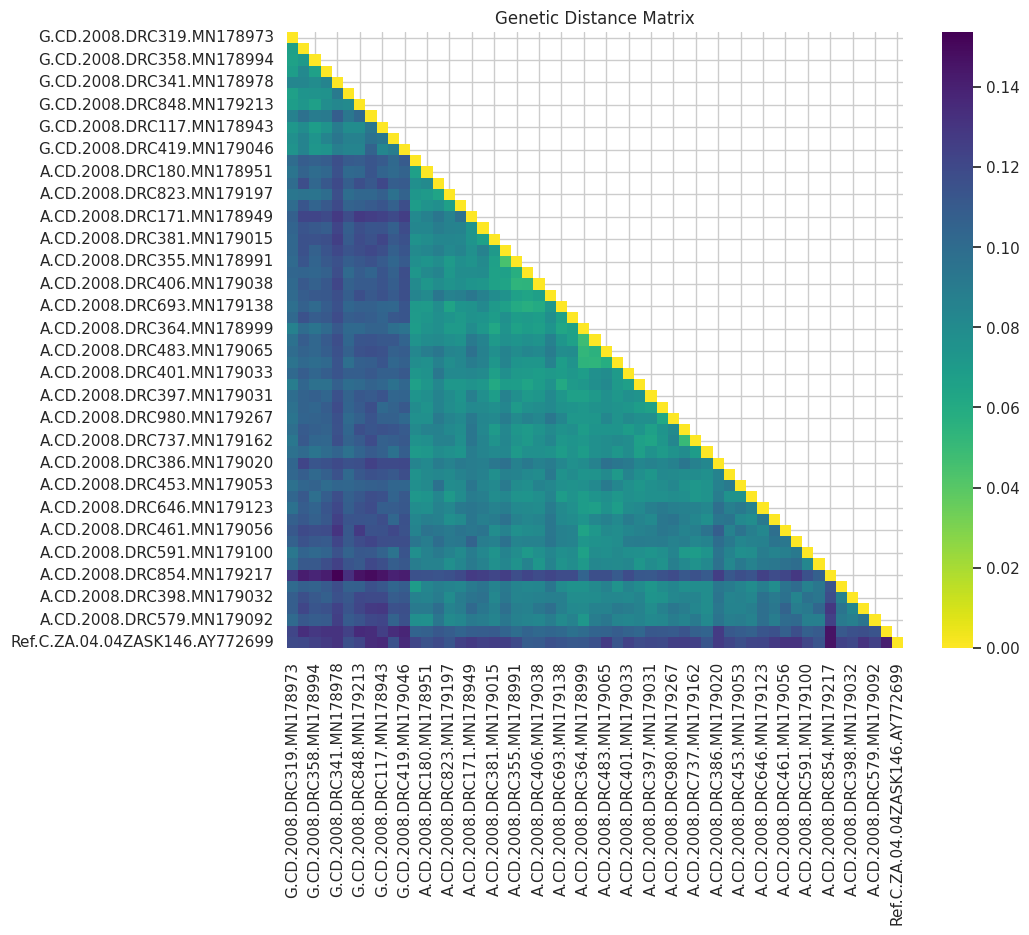

In [14]:
# calculate the pairwise distance matrix
calculator = DistanceCalculator('identity')
alignment = MultipleSeqAlignment(sequences)
dmatrix = calculator.get_distance(alignment)

# convert distance matrix to a DataFrame for visualization
dist_df = pd.DataFrame(dmatrix.matrix, index=dmatrix.names, columns=dmatrix.names)

# plot the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(dist_df, cmap='viridis_r', square=True)
plt.title("Genetic Distance Matrix")
plt.show()

### Building a Neighbor-Joining Tree

We would now like to visualise the relationship between these sequences in a more informative way by building a phylogeny. Build a tree using the neighbour-joining algorithm. Colour the tip labels according to HIV subtype, which is contained in the first part of the taxa labels.

Plot the tree. What do you notice? Which tips share a common ancestor? Do any of the tree features suggest something has gone wrong with the phylogenetic inference?

In [16]:
# build a neighbor-joining tree
constructor = DistanceTreeConstructor()
nj_tree = constructor.nj(dmatrix)

# plot the tree using ete3
#plt_tree = Tree(nj_tree.format('newick'), format=1)
#tree_style = TreeStyle()
#tree_style.show_leaf_name = True
#tree_style.scale = 50

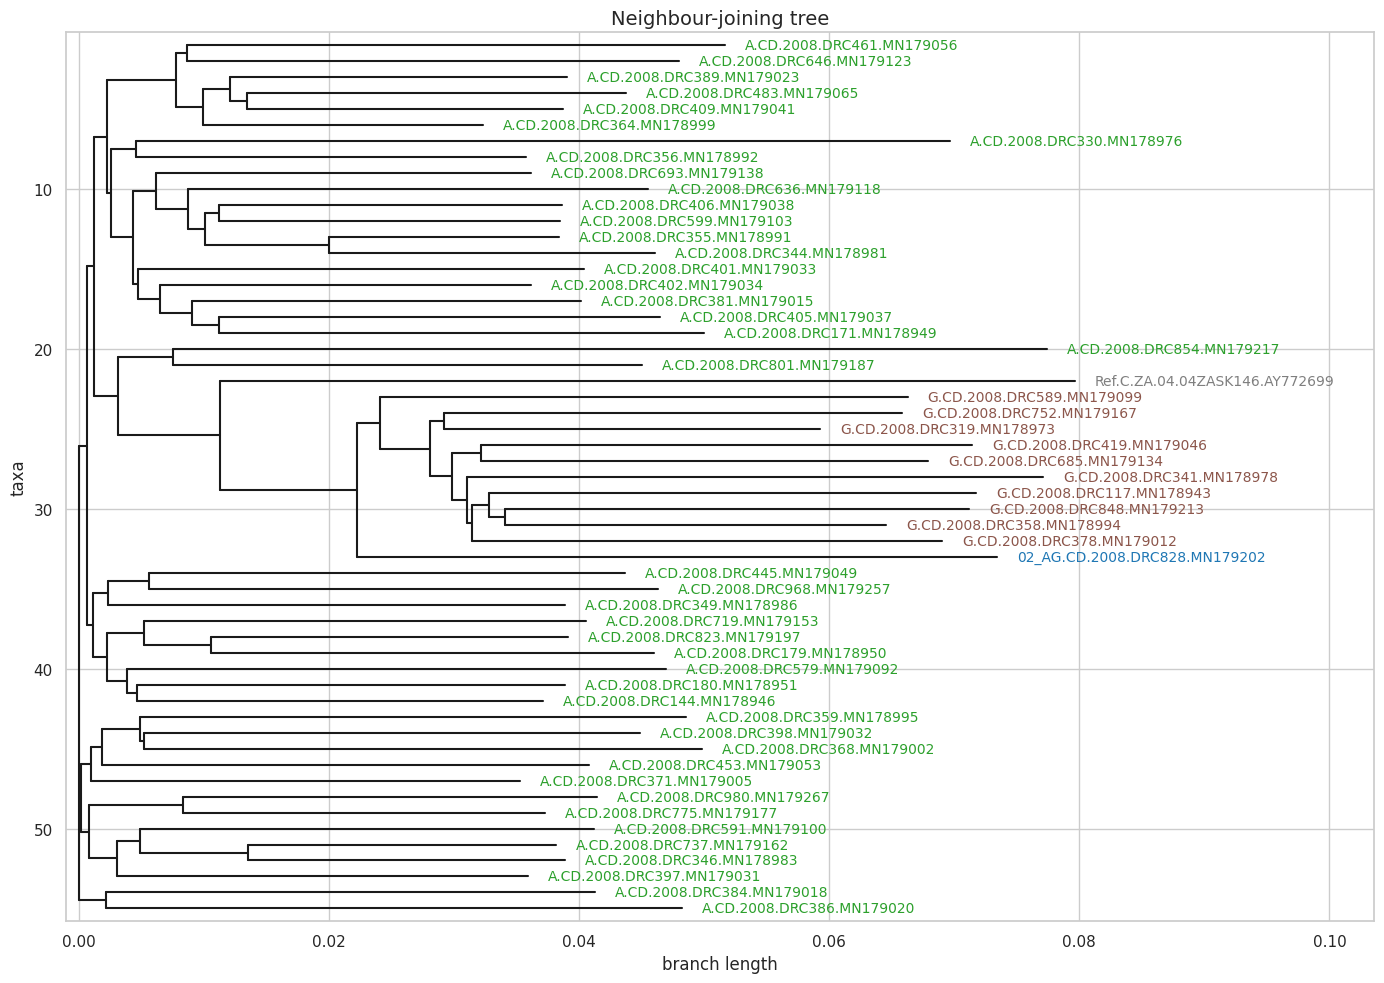

In [19]:
# reformat tree to colour the tips according to HIV subtype

# function to extract subtype from tip labels
def extract_subtype(label):
    match = re.match(r"([A-Za-z0-9_]+).*", label)
    return match.group(1) if match else "Unknown"

# get tip labels and extract HIV subtypes
tip_labels = [clade.name for clade in nj_tree.get_terminals()]
subtypes = {label: extract_subtype(label) for label in tip_labels}

# define a color map for HIV subtypes
unique_subtypes = sorted(set(subtypes.values()))
color_palette = plt.get_cmap("tab10")  # Get distinct colors
color_map = {st: color_palette(i / len(unique_subtypes)) for i, st in enumerate(unique_subtypes)}

# plot tree
fig, ax = plt.subplots(figsize=(14, 10))

# plot tree without default labels
Phylo.draw(nj_tree, axes=ax, label_func=lambda x: None, do_show=False)
plt.draw()

# Get y coordinates for labels from the tree
y_coords = {leaf: y for y, leaf in enumerate(nj_tree.get_terminals())}

# get x coordinates for labels (branch tip locations)
x_coords = {leaf: sum(c.branch_length or 0 for c in nj_tree.get_path(leaf)) for leaf in nj_tree.get_terminals()}

# shift values to be correctly aligned
x_shift = max(x_coords.values()) * 0.02
y_shift = -1

# add new coloured labels
for clade in nj_tree.get_terminals():
    if clade.name:
        subtype = subtypes.get(clade.name, "Unknown")
        color = color_map[subtype]

        parent_x = x_coords[clade]
        y_pos = y_coords[clade] - y_shift

        ax.text(parent_x + x_shift, y_pos, clade.name,
                fontsize=10, color=color, verticalalignment="center")

# expand x-axis to fit new labels and adjust plot margins
ax.set_xlim(left=-0.001, right=max(x_coords.values()) + (x_shift * 15))

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# plot tree
plt.title("Neighbour-joining tree", fontsize=14)
plt.tight_layout()

# save tree
out_path = os.path.join(output_dir, 'nj_tree_colST.png')
plt.savefig(out_path, dpi=300, bbox_inches="tight")

# plot tree
plt.show()


### Correcting Alignment Errors
See if you can find the reason for the long branch by taking a look at the alignment.

Open the .fasta file with an alignment viewer such as AliView or jalview and see if you can find and correct the alignment error. Hint: remember that the sequences in the alignment must all be the same length.

Export the amended alignment and save it with the name 'hiv_fixedalignment.fasta'. Alternatively, this file can be downloaded from the repo with the code below.

Read in the new .fasta file and repeat the steps above using the following code. Now the distance matrix no longer shows large differences between all sequences and the misaligned sequence. The long branch has also gone from the tree.

What else do you notice about how the HIV-1 subtypes cluster in the tree from their coloured tips?

curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60949  100 60949    0     0   226k      0 --:--:-- --:--:-- --:--:--  226k


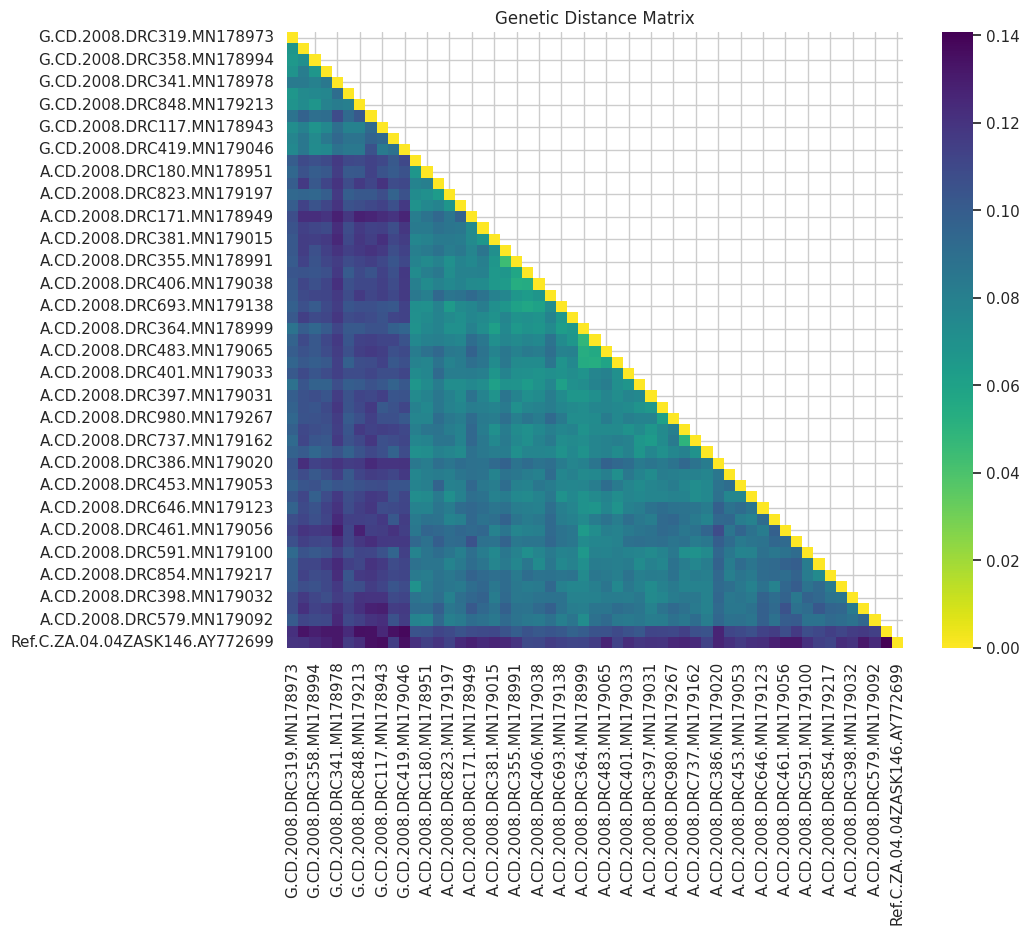

In [20]:
# Reload the corrected alignment
!curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/day5/practical6/data/hiv_fixedalignment.fasta"

corrected_sequences = list(SeqIO.parse("hiv_fixedalignment.fasta", "fasta"))

# recompute distance matrix
corrected_alignment = MultipleSeqAlignment(corrected_sequences)
corrected_dmatrix = calculator.get_distance(corrected_alignment)

# convert to a DataFrame
dist_df = pd.DataFrame(corrected_dmatrix.matrix, index=corrected_dmatrix.names, columns=corrected_dmatrix.names)

# plot the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(dist_df, cmap='viridis_r', square=True)
plt.title("Genetic Distance Matrix")
plt.show()



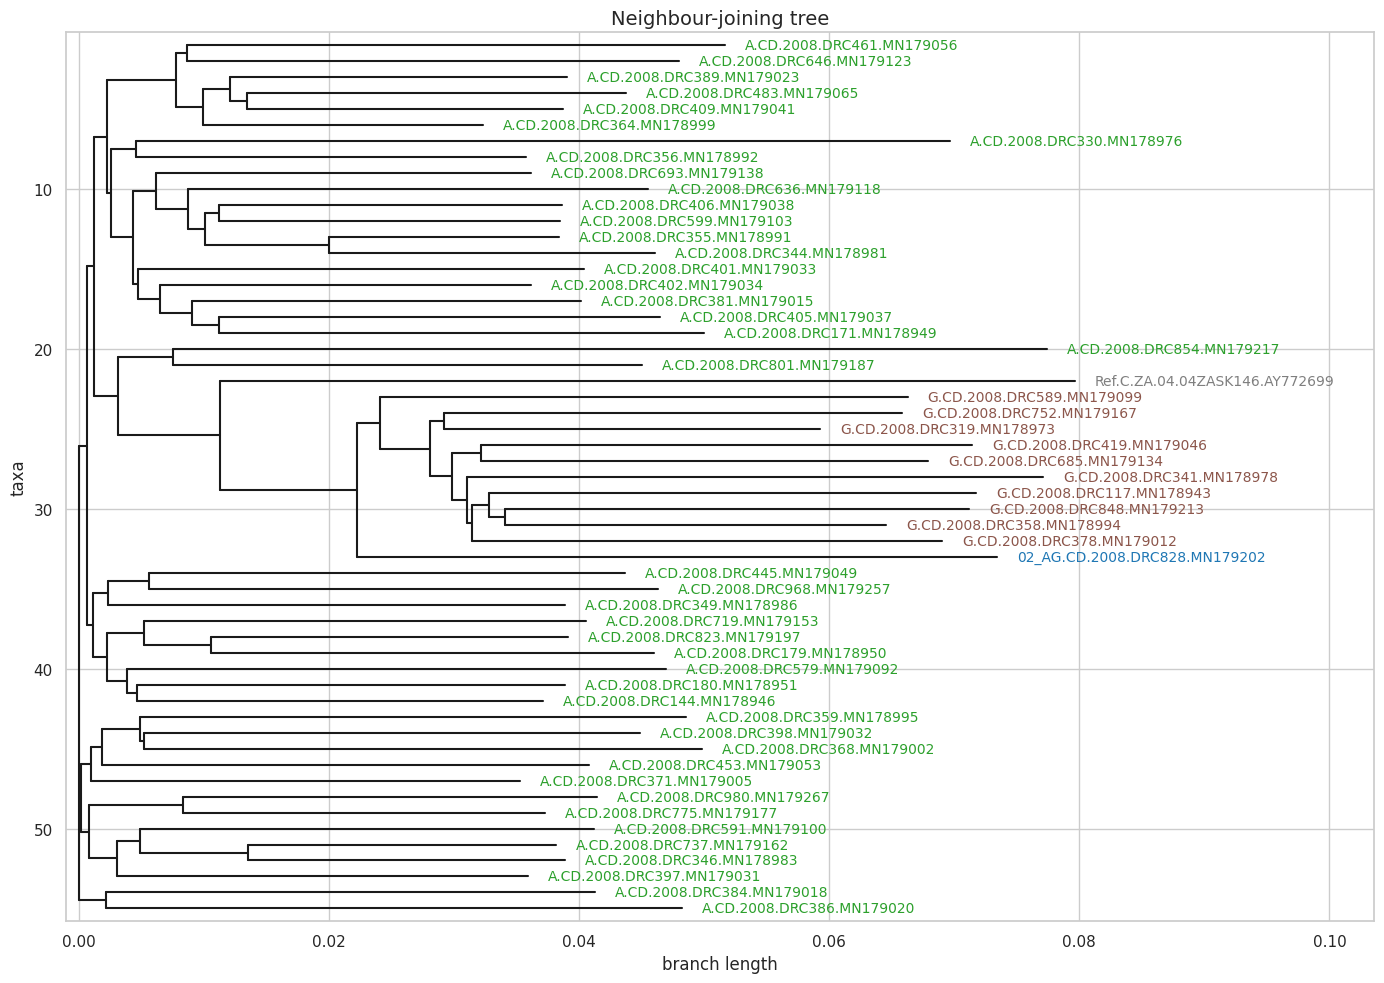

In [21]:
corrected_tree = constructor.nj(corrected_dmatrix)

# get tip labels and extract HIV subtypes
tip_labels = [clade.name for clade in nj_tree.get_terminals()]
subtypes = {label: extract_subtype(label) for label in tip_labels}

# define a color map for HIV subtypes
unique_subtypes = sorted(set(subtypes.values()))
color_palette = plt.get_cmap("tab10")  # Get distinct colors
color_map = {st: color_palette(i / len(unique_subtypes)) for i, st in enumerate(unique_subtypes)}

# plot tree
fig, ax = plt.subplots(figsize=(14, 10))

# plot tree without default labels
Phylo.draw(nj_tree, axes=ax, label_func=lambda x: None, do_show=False)
plt.draw()

# Get y coordinates for labels from the tree
y_coords = {leaf: y for y, leaf in enumerate(nj_tree.get_terminals())}

# get x coordinates for labels (branch tip locations)
x_coords = {leaf: sum(c.branch_length or 0 for c in nj_tree.get_path(leaf)) for leaf in nj_tree.get_terminals()}

# shift values to be correctly aligned
x_shift = max(x_coords.values()) * 0.02
y_shift = -1

# add new coloured labels
for clade in nj_tree.get_terminals():
    if clade.name:
        subtype = subtypes.get(clade.name, "Unknown")
        color = color_map[subtype]

        parent_x = x_coords[clade]
        y_pos = y_coords[clade] - y_shift

        ax.text(parent_x + x_shift, y_pos, clade.name,
                fontsize=10, color=color, verticalalignment="center")

# expand x-axis to fit new labels and adjust plot margins
ax.set_xlim(left=-0.001, right=max(x_coords.values()) + (x_shift * 15))

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# plot tree
plt.title("Neighbour-joining tree", fontsize=14)
plt.tight_layout()

# save tree
out_path = os.path.join(output_dir, 'corrected_alignment_nj_tree_colST.png')
plt.savefig(out_path, dpi=300, bbox_inches="tight")

# plot tree
plt.show()


### Remove the recombinant

We notice that there is a recombinant of subtypes A and G (light blue tip). The algorithm doesn’t know where to put it in the tree, and we have a clade of both subtype A and subtype G viruses, whereas we’d expect the subtype A viruses to share a most recent common ancestor with all other subtype A sequences, and same for subtype G. What happens if we remove it?

Hint: search among the taxa labels for the recombinant.

Note that it is not necessary to exclude recombinants from phylogenetic analyses as a rule. However we have to be careful how we handle them. If we are interested in a particular recombinant circulating in the population, we might generate a separate phylogeny for just that circulating recombinant form.

Filtered alignment saved as: drive/MyDrive/StatML4PopHealth/practical6/hiv/alignment_worecombinant.fasta


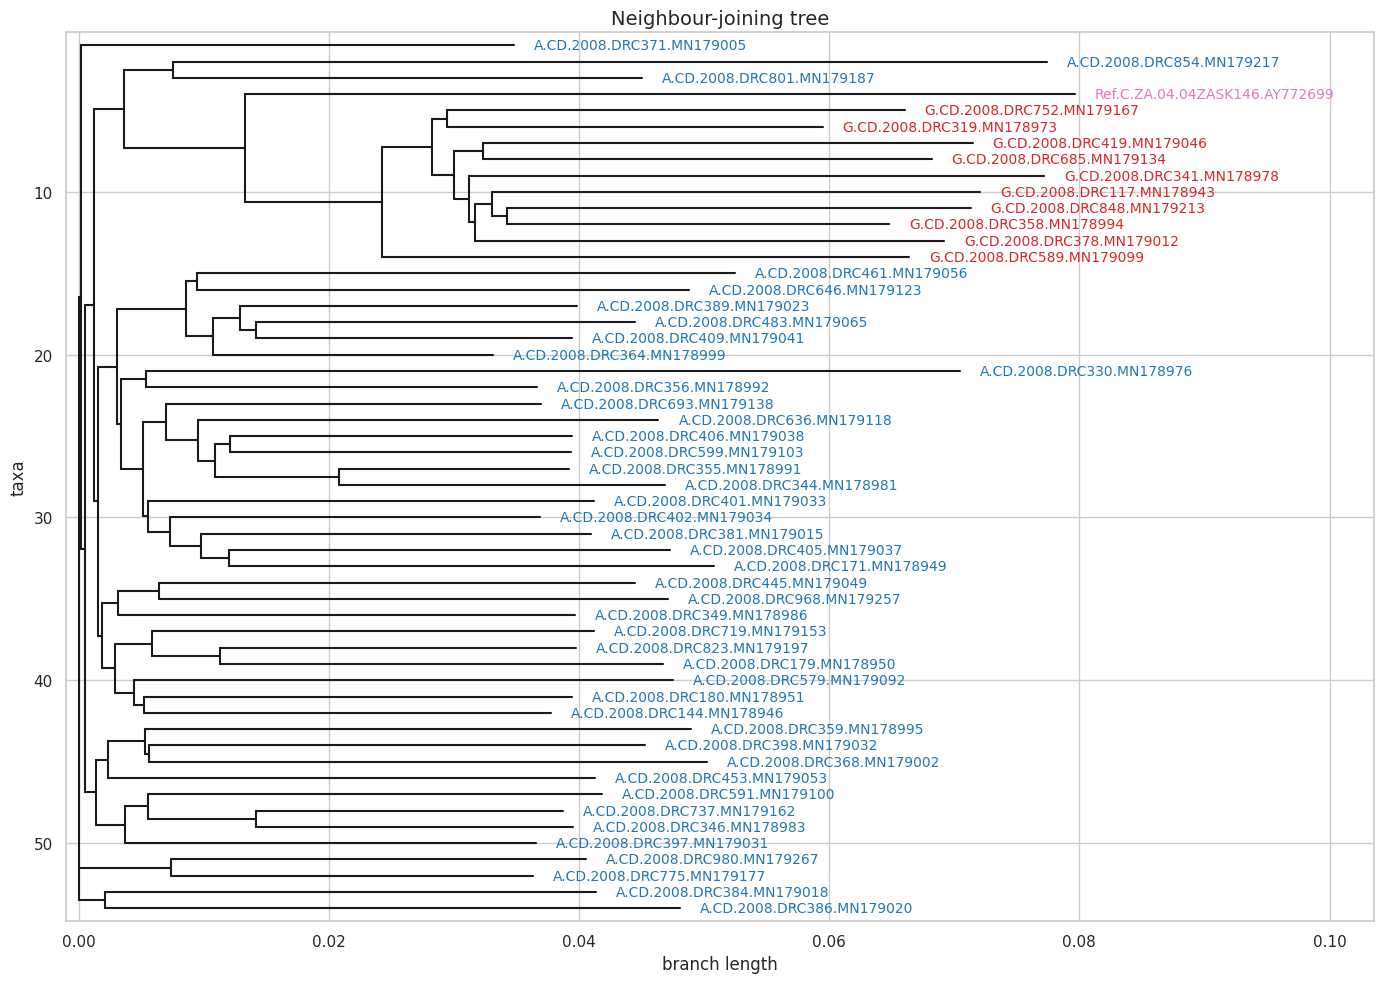

In [22]:

# extract taxon labels
labels = [seq.id for seq in sequences]

# find recombinant taxa (not G, A, or Ref)**
to_remove = [label for label in labels if not re.match(r'^(G|A|.*ref.*)', label, re.IGNORECASE)]

# remove recombinant taxa
filtered_sequences = [seq for seq in sequences if seq.id not in to_remove]
filtered_sequences = MultipleSeqAlignment(filtered_sequences)

# save alignment without recombinants
filtered_alignment = os.path.join(output_dir, "alignment_worecombinant.fasta")  # Cleaned alignment (no recombinants)
SeqIO.write(filtered_sequences, filtered_alignment, "fasta")
print(f"Filtered alignment saved as: {filtered_alignment}")

# compute distance matrix
calculator = DistanceCalculator("identity")
dmatrix = calculator.get_distance(filtered_sequences)

# generate neighbor-joining tree**
constructor = DistanceTreeConstructor()
nj_tree = constructor.nj(dmatrix)

# get tip labels and extract HIV subtypes
tip_labels = [clade.name for clade in nj_tree.get_terminals()]
subtypes = {label: extract_subtype(label) for label in tip_labels}

# define a color map for HIV subtypes
unique_subtypes = sorted(set(subtypes.values()))
color_palette = plt.get_cmap("tab10")  # Get distinct colors
color_map = {st: color_palette(i / len(unique_subtypes)) for i, st in enumerate(unique_subtypes)}

# plot tree
fig, ax = plt.subplots(figsize=(14, 10))

# plot tree without default labels
Phylo.draw(nj_tree, axes=ax, label_func=lambda x: None, do_show=False)
plt.draw()

# Get y coordinates for labels from the tree
y_coords = {leaf: y for y, leaf in enumerate(nj_tree.get_terminals())}

# get x coordinates for labels (branch tip locations)
x_coords = {leaf: sum(c.branch_length or 0 for c in nj_tree.get_path(leaf)) for leaf in nj_tree.get_terminals()}

# shift values to be correctly aligned
x_shift = max(x_coords.values()) * 0.02
y_shift = -1

# add new coloured labels
for clade in nj_tree.get_terminals():
    if clade.name:
        subtype = subtypes.get(clade.name, "Unknown")
        color = color_map[subtype]

        parent_x = x_coords[clade]
        y_pos = y_coords[clade] - y_shift

        ax.text(parent_x + x_shift, y_pos, clade.name,
                fontsize=10, color=color, verticalalignment="center")

# expand x-axis to fit new labels and adjust plot margins
ax.set_xlim(left=-0.001, right=max(x_coords.values()) + (x_shift * 15))

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# plot tree
plt.title("Neighbour-joining tree", fontsize=14)
plt.tight_layout()

# save tree
out_path = os.path.join(output_dir, 'corrected_alignment_nj_tree_colST.png')
plt.savefig(out_path, dpi=300, bbox_inches="tight")

# plot tree
plt.show()


### Rooting the Tree

The reference sequence (subtype C) is part of the G clade, and we still have some subtype A sequences in a clade with subtype G sequences. In general, the topology can be misleading if the tree is not rooted, especially with respect to isolates. We can tell the algorithm where the root should be by specifying the outgroup (the sequence beginning with Ref.).

Recall that the outgroup should be a sequence from outside the study population, but genetically similar. We use a subtype C sequence, which is genetically close to both subtypes A and G.

We root the tree by specifying the outgroup. By rooting the tree, the reference sequence has moved to be the ancestor of all the taxa. We now also see that all the subtype G taxa are in one clade, and all the subtype A taxa are in another.

Outgroup set to: Ref.C.ZA.04.04ZASK146.AY772699
Tree successfully re-rooted with 54 terminal nodes.


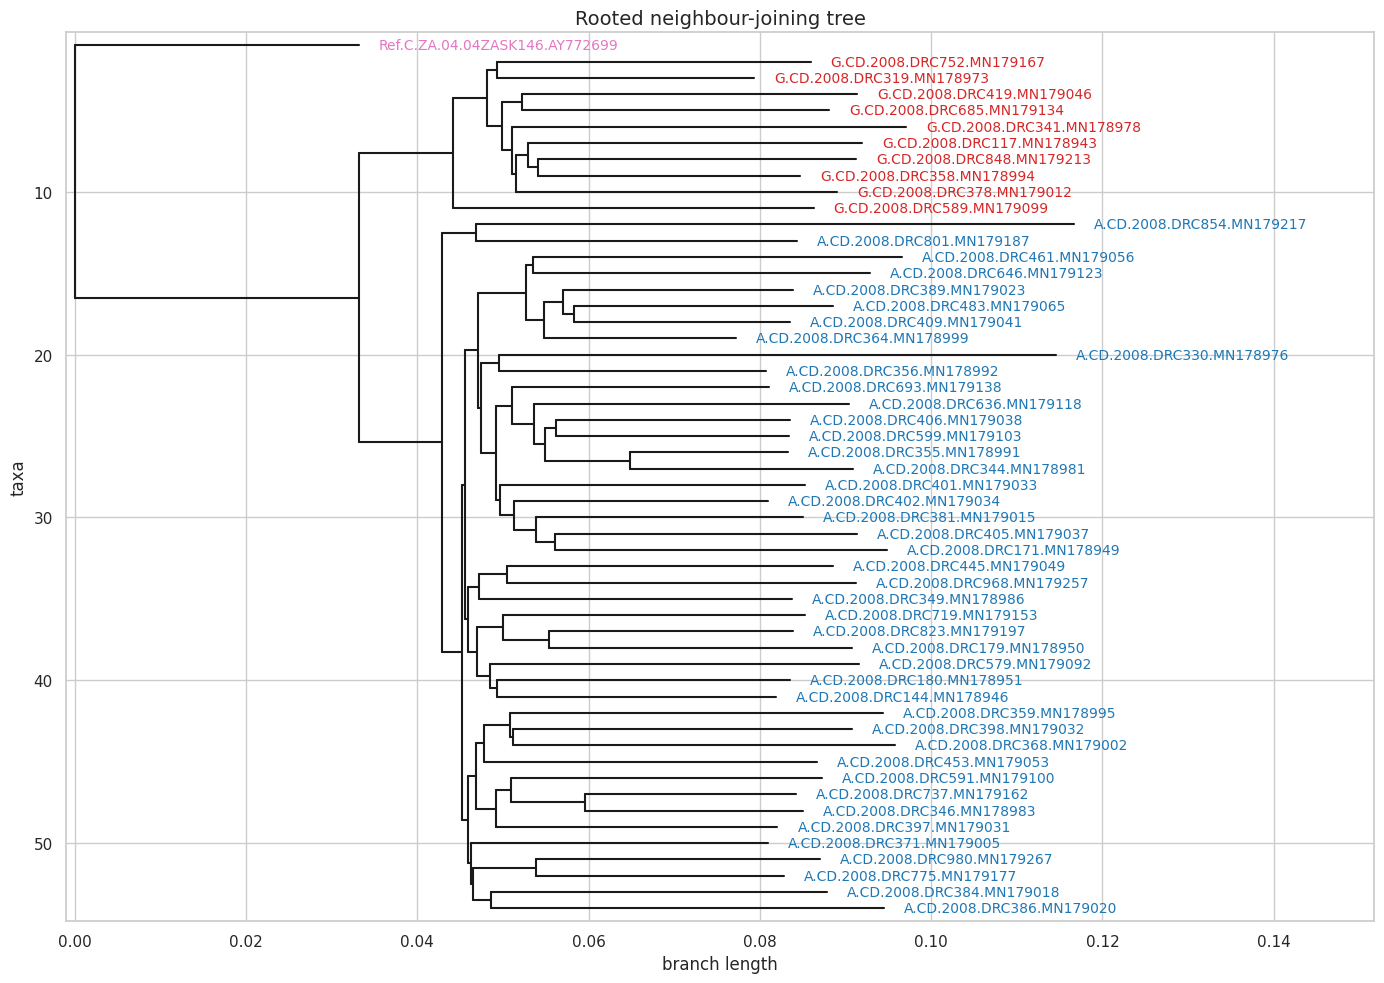

Tree saved successfully at: drive/MyDrive/StatML4PopHealth/practical6/hiv/rooted_nj_tree_colST.png


In [24]:
# first convert tree to newick format
newick_tree = Tree(nj_tree.format('newick'), format=1)

# find the first label containing "ref" (reference sequence for outgroup)
outgroup_label = None
for leaf in newick_tree.iter_leaves():
    if re.search(r'ref', leaf.name, re.IGNORECASE):
        outgroup_label = leaf.name
        break

# if an outgroup was found, set it (reoot the tree)
if outgroup_label:
    newick_tree.set_outgroup(outgroup_label)
    print(f"Outgroup set to: {outgroup_label}")
else:
    print("No matching outgroup found!")

# convert newick tree format
newick_string = newick_tree.write(format=1)
newick_io = io.StringIO(newick_string)

rooted_tree = Phylo.read(newick_io, "newick")
print(f"Tree successfully re-rooted with {len(rooted_tree.get_terminals())} terminal nodes.")

# plot the re-rooted tree
# get tip labels and extract HIV subtypes
tip_labels = [clade.name for clade in rooted_tree.get_terminals()]
subtypes = {label: extract_subtype(label) for label in tip_labels}

# define a color map for HIV subtypes
unique_subtypes = sorted(set(subtypes.values()))
color_palette = plt.get_cmap("tab10")  # Get distinct colors
color_map = {st: color_palette(i / len(unique_subtypes)) for i, st in enumerate(unique_subtypes)}

# plot tree
fig, ax = plt.subplots(figsize=(14, 10))

# plot tree without default labels
Phylo.draw(rooted_tree, axes=ax, label_func=lambda x: None, do_show=False)
plt.draw()

# Get y coordinates for labels from the tree
y_coords = {leaf: y for y, leaf in enumerate(rooted_tree.get_terminals())}

# get x coordinates for labels (branch tip locations)
x_coords = {leaf: sum(c.branch_length or 0 for c in rooted_tree.get_path(leaf)) for leaf in rooted_tree.get_terminals()}

# shift values to be correctly aligned
x_shift = max(x_coords.values()) * 0.02
y_shift = -1

# add new coloured labels
for clade in rooted_tree.get_terminals():
    if clade.name:
        subtype = subtypes.get(clade.name, "Unknown")
        color = color_map[subtype]

        parent_x = x_coords[clade]
        y_pos = y_coords[clade] - y_shift

        ax.text(parent_x + x_shift, y_pos, clade.name,
                fontsize=10, color=color, verticalalignment="center")

# expand x-axis to fit new labels and adjust plot margins
ax.set_xlim(left=-0.001, right=max(x_coords.values()) + (x_shift * 15))

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# plot tree
plt.title("Rooted neighbour-joining tree", fontsize=14)
plt.tight_layout()

# save tree
out_path = os.path.join(output_dir, 'rooted_nj_tree_colST.png')
plt.savefig(out_path, dpi=300, bbox_inches="tight")

# Plot tree
plt.show()
print(f"Tree saved successfully at: {out_path}")


### Extract a clade

Sometimes we might be particularly interested in a single clade from the tree. See if you can extract the G clade and plot it by filling in the gaps in the code.
- Find the MRCA of the farthest apart taxa in the G clade of the tree
- Extract the subtree

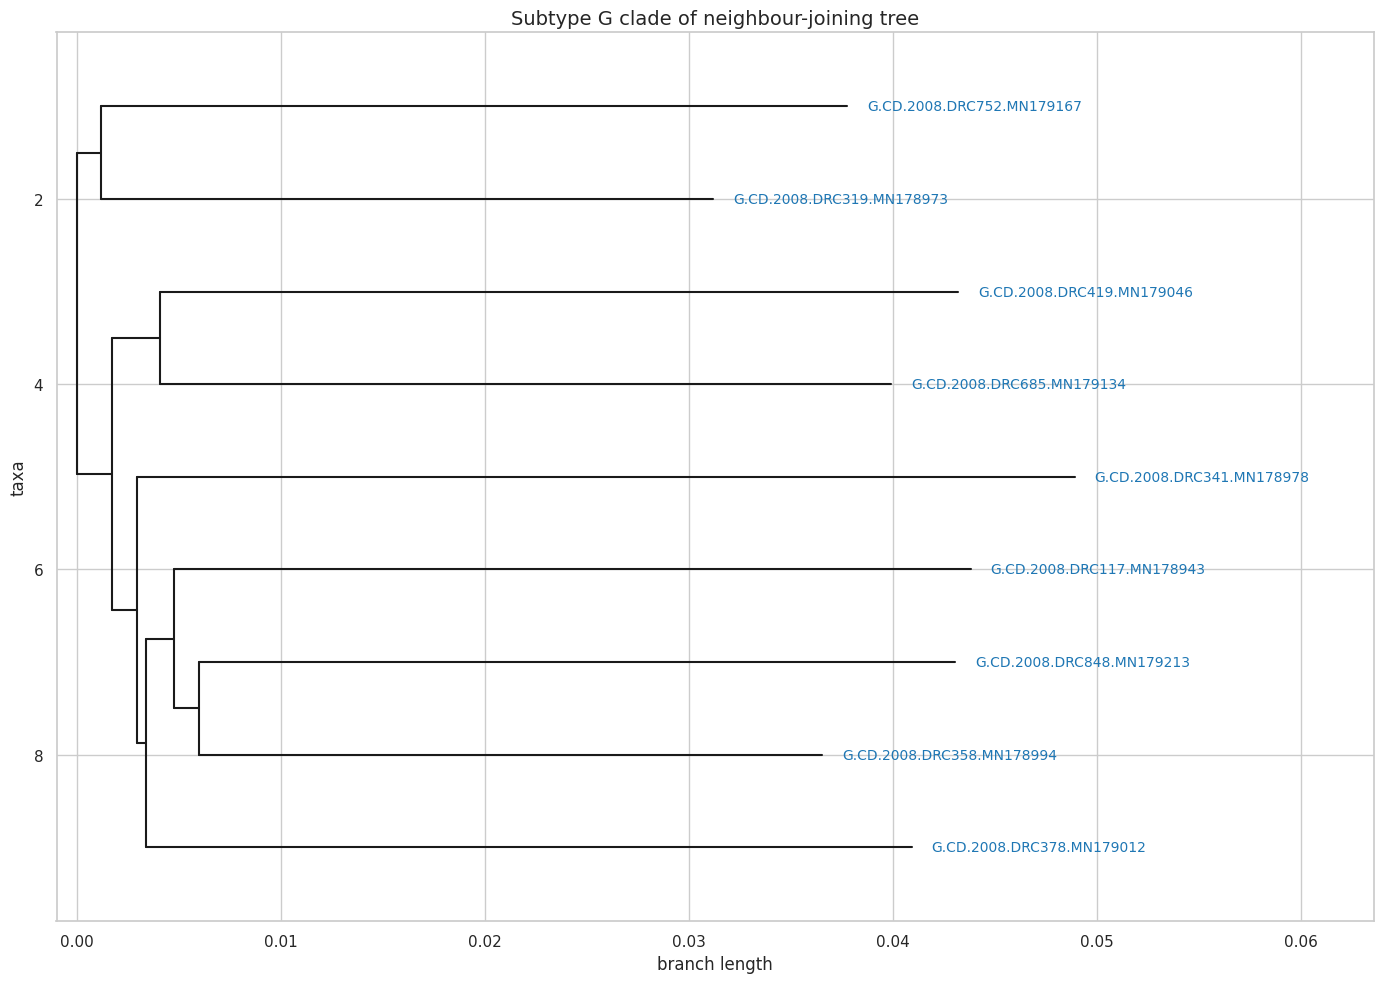

Tree saved successfully at: drive/MyDrive/StatML4PopHealth/practical6/hiv/Gclade_colST.png


In [25]:

# convert tree to newick format
ete_tree = Tree(rooted_tree.format("newick"), format=1)

# list two subtype G taxa in the tree
taxon1 = "G.CD.2008.DRC319.MN178973"
taxon2 = "G.CD.2008.DRC358.MN178994"

# find the MRCA of the two taxa
mrca_node = ete_tree.get_common_ancestor(taxon1, taxon2)

# extract subtree
G_clade = mrca_node.detach()

# convert subtree format to newick for plotting
subtree_newick = G_clade.write(format=1)
subtree_io = io.StringIO(subtree_newick)
clade = Phylo.read(subtree_io, "newick")

# get tip labels and extract HIV subtypes
tip_labels = [clade.name for clade in clade.get_terminals()]
subtypes = {label: extract_subtype(label) for label in tip_labels}

# define a color map for HIV subtypes
unique_subtypes = sorted(set(subtypes.values()))
color_palette = plt.get_cmap("tab10")  # Get distinct colors
color_map = {st: color_palette(i / len(unique_subtypes)) for i, st in enumerate(unique_subtypes)}

# plot tree
fig, ax = plt.subplots(figsize=(14, 7))

# plot tree without default labels
Phylo.draw(clade, axes=ax, label_func=lambda x: None, do_show=False)
plt.draw()

# Get y coordinates for labels from the tree
y_coords = {leaf: y for y, leaf in enumerate(clade.get_terminals())}

# get x coordinates for labels (branch tip locations)
x_coords = {leaf: sum(c.branch_length or 0 for c in clade.get_path(leaf)) for leaf in clade.get_terminals()}

# shift values to be correctly aligned
x_shift = max(x_coords.values()) * 0.02
y_shift = -1

# add new coloured labels
for clade in clade.get_terminals():
    if clade.name:
        subtype = subtypes.get(clade.name, "Unknown")
        color = color_map[subtype]

        parent_x = x_coords[clade]
        y_pos = y_coords[clade] - y_shift

        ax.text(parent_x + x_shift, y_pos, clade.name,
                fontsize=10, color=color, verticalalignment="center")

# expand x-axis to fit new labels and adjust plot margins
ax.set_xlim(left=-0.001, right=max(x_coords.values()) + (x_shift * 15))

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# plot tree
plt.title("Subtype G clade of neighbour-joining tree", fontsize=14)
plt.tight_layout()

# save tree
out_path = os.path.join(output_dir, 'Gclade_colST.png')
plt.savefig(out_path, dpi=300, bbox_inches="tight")

# Plot tree
plt.show()
print(f"Tree saved successfully at: {out_path}")


### Re-build tree using maximum likelihood estimation

We will finally re-estimate the tree using a maximum-likelihood approach (Felsenstein, 1981), which uses the sequence data in a statistical framework where we seek to estimate model parameters. There other approaches to building trees we will not cover here, such as maximum parsimony, but you can explore these yourself.

We will use the RaxML (Randomized Axelerated Maximum Likelihood) package.

We will assume the GTR with the Gamma model for rate heterogeneity, and specify the outgroup for rooting.

In [ ]:
# run RAxML for ML tree estimation

if not os.path.exists(ml_tree_file):

    try:
        !raxml-ng --msa {filtered_alignment} --model GTR+G --prefix ml_tree --tree pars --redo --outgroup {outgroup_label}
        print("RAxML-NG successfully ran!")
    except subprocess.CalledProcessError:
        print("Error running RAxML. Ensure RAxML-NG is installed.")



RAxML-NG v. 1.2.2 released on 11.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) CPU @ 2.20GHz, 1 cores, 12 GB RAM

RAxML-NG was called at 25-Mar-2025 15:06:50 as follows:

raxml-ng --msa drive/MyDrive/StatML4PopHealth/practical6/hiv/alignment_worecombinant.fasta --model GTR+G --prefix ml_tree --tree pars --redo --outgroup Ref.C.ZA.04.04ZASK146.AY772699

Analysis options:
  run mode: ML tree search
  start tree(s): parsimony (10)
  outgroup taxa: Ref.C.ZA.04.04ZASK146.AY772699
  random seed: 1742915210
  tip-inner: OFF
  pattern compression: ON
  per-rate scalers: OFF
  site repeats: ON
  logLH epsilon: general: 10.000000, brlen-triplet: 1000.000000
  fas

In [ ]:
# plot the tree

# load the ML Tree
ml_tree = Phylo.read("ml_tree.raxml.bestTree","newick")

# root the tree
outgroup_label = None
for leaf in ml_tree.get_terminals():
    if re.search(r'ref', leaf.name, re.IGNORECASE):
        outgroup_label = leaf.name
        break

if outgroup_label:
    ml_tree.root_with_outgroup(outgroup_label)
    print(f"Tree rooted with outgroup: {outgroup_label}")
else:
    print("No reference sequence found for rooting!")

# color tip Labels by HIV subtype
tip_labels = [clade.name for clade in ml_tree.get_terminals()]
subtype_groups = {"G": "red", "A": "blue"}
default_color = "black"

subtypes = {label: next((k for k in subtype_groups if label.startswith(k)), "Other") for label in tip_labels}

# define a color map for HIV subtypes
unique_subtypes = sorted(set(subtypes.values()))
color_palette = plt.get_cmap("tab10")  # Get distinct colors
color_map = {st: color_palette(i / len(unique_subtypes)) for i, st in enumerate(unique_subtypes)}

# plot tree
fig, ax = plt.subplots(figsize=(12, 8))

Phylo.draw(ml_tree, axes=ax, label_func=lambda x: None, do_show=False)
plt.draw()  # Ensure tree is rendered before annotation

# compute x, y coordinates for tip labels
y_coords = {leaf: y for y, leaf in enumerate(ml_tree.get_terminals())}
x_coords = {leaf: sum(c.branch_length or 0 for c in ml_tree.get_path(leaf)) for leaf in ml_tree.get_terminals()}

# add tip labels with colors
x_shift = max(x_coords.values()) * 0.005
y_shift = -1

for clade in ml_tree.get_terminals():
    if clade.name:
        subtype = subtypes.get(clade.name, "Other")
        color = color_map[subtype]

        parent_x = x_coords[clade]
        y_pos = y_coords[clade] - y_shift

        ax.text(parent_x + x_shift, y_pos, clade.name,
                fontsize=8, color=color, verticalalignment="center")

# add bootstrap support on internal nodes
for clade in ml_tree.get_nonterminals():
    if clade.confidence:
        parent_x = sum(c.branch_length or 0 for c in ml_tree.get_path(clade))
        y_pos = y_coords[clade.clades[0]] - 0.5

        ax.text(parent_x, y_pos, f"{clade.confidence:.0f}",
                fontsize=8, color="black", verticalalignment="center",
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# formatting
max_x = max(x_coords.values()) + (x_shift * 5)
ax.set_xlim(left=-0.001, right=max(x_coords.values()) + (x_shift * 50))

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.title("Maximum Likelihood Tree (Rooted at outgroup)", fontsize=12)

# save
ml_tree_pdf = os.path.join(output_dir, "ml_tree_no_recombinants_rooted.pdf")
plt.savefig(ml_tree_pdf, format="pdf", bbox_inches="tight")
print(f"ML Tree saved successfully at: {ml_tree_pdf}")

# plot tree
plt.show()


NameError: name 'Phylo' is not defined

### Compare ML tree with NJ tree

We could also optimise for a different evolution model, with the --model option, set to e.g. ‘JC’ (Jukes and Cantor) or ‘GTR’ (Gamma model).

We can then compare the optimal tree with the initial tree with a likelihood ratio test and confirm that it has a substantially larger likelihood and a lower AIC, indicating the optimised tree is better model for the sequence data.

In [42]:

# paths to RaxML output files
raxml_log_file = "ml_tree.raxml.log"  # log file containing likelihoods
best_tree_file = "ml_tree.raxml.bestTree"  # optimized tree
initial_tree_file = "ml_tree.raxml.startTree"  # initial tree

# function to extract likelihoods for initial tree and best tree from log file
def extract_likelihoods(log_file):
    """Extracts the first and final log-likelihoods from the RAxML log file."""
    best_likelihood, initial_likelihood = None, None

    if not os.path.exists(log_file):
        print(f" Error: Log file not found: {log_file}")
        return None, None

    with open(log_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        if "logLikelihood:" in line:
            match = re.search(r"logLikelihood:\s+(-?\d+\.\d+)", line)
            if match:
                initial_likelihood = float(match.group(1))
                print(f"- Extracted Initial LogLikelihood: {initial_likelihood}")
                break

    # extract final loglikelihood
    for line in reversed(lines):
        if "Final LogLikelihood:" in line:
            match = re.search(r"Final LogLikelihood:\s+(-?\d+\.\d+)", line)
            if match:
                best_likelihood = float(match.group(1))
                print(f"- Extracted Final LogLikelihood from best tree: {best_likelihood}")
                break

    if initial_likelihood is None or best_likelihood is None:
        print("Error: Could not extract likelihood values from the log file!")

    return initial_likelihood, best_likelihood

# function to compute likelihood ratio test (LRT)
def likelihood_ratio_test(initial_L, best_L, df=1):
    """ Perform a likelihood ratio test (LRT) between two models. """
    if initial_L is None or best_L is None:
        print("Cannot perform LRT: Likelihood values missing.")
        return None, None

    LRT_stat = 2 * (best_L - initial_L)  c
    p_value = chi2.sf(LRT_stat, df)
    return LRT_stat, p_value

# function to compute AIC
def compute_aic(log_likelihood, num_params):
    """ Compute Akaike Information Criterion (AIC). """
    if log_likelihood is None:
        return None
    return 2 * num_params - 2 * log_likelihood

# compare trees
# extract Likelihoods from RAxML Logs
if os.path.exists(raxml_log_file):
    initial_logL, best_logL = extract_likelihoods(raxml_log_file)


    if initial_logL is not None and best_logL is not None:
        print(f"\n Likelihood Values:")
        print(f"  - Initial Log-Likelihood: {initial_logL}")
        print(f"  - Optimized ML Tree Log-Likelihood: {best_logL}")

        # perform Likelihood Ratio Test
        LRT_stat, p_value = likelihood_ratio_test(initial_logL, best_logL)
        if LRT_stat is not None:
            print(f"\n Likelihood Ratio Test:")
            print(f"  - Test Statistic: {LRT_stat:.2f}")
            print(f"  - P-Value: {p_value:.4f} (Significant if < 0.05)")

        # compute AIC for both trees
        num_params = 10
        aic_initial = compute_aic(initial_logL, num_params)
        aic_best = compute_aic(best_logL, num_params)

        print(f"\n AIC Scores:")
        print(f"  - AIC (Initial Tree): {aic_initial:.2f}")
        print(f"  - AIC (Optimized Tree): {aic_best:.2f}")

        if best_logL > initial_logL and aic_best < aic_initial:
            print("\n Optimized ML tree is a significantly better model (higher likelihood, lower AIC).")
        else:
            print("\n Optimized tree is not significantly better. Check model assumptions.")

else:
    print(" RAxML log file not found! Ensure RAxML completed successfully.")


- Extracted Initial LogLikelihood: -10739.033311
- Extracted Final LogLikelihood from best tree: -10738.369384

📊 Likelihood Values:
  - Initial Log-Likelihood: -10739.033311
  - Optimized ML Tree Log-Likelihood: -10738.369384

🔬 Likelihood Ratio Test:
  - Test Statistic: 1.33
  - P-Value: 0.2492 (Significant if < 0.05)

📈 AIC Scores:
  - AIC (Initial Tree): 21498.07
  - AIC (Optimized Tree): 21496.74

✅ Optimized ML tree is a significantly better model (higher likelihood, lower AIC).


## Bootstrapping

We would finally like to quantify how robust our tree is.

Using RAxML, we bootstrap resample each site of the alignment with replacement, carry out phylogenetic inference using the maximum likelihood approach as before, and plot the tree with each clade labelled with the number of bootstrapped trees in which we observe this clade. If the tree is robust, we would hope to observe the same clades across the original tree and the bootstrap trees.

What do you notice about the values?

Some of the bootstrap values at the internal nodes are quite low, which means some of these nodes are not well supported. However the subtype G clade and C clades are well supported, appearing in 99% and 86% respectively of optimised trees constructed from bootstrapped alignments, so we can be quite confident about their position in the phylogeny.


RAxML-NG v. 1.2.2 released on 11.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) CPU @ 2.20GHz, 1 cores, 12 GB RAM

RAxML-NG was called at 25-Mar-2025 15:52:49 as follows:

raxml-ng --bootstrap --msa drive/MyDrive/StatML4PopHealth/practical6/hiv/alignment_worecombinant.fasta --model GTR+G --prefix T2 --threads 2 --bs-tree 100 --outgroup Ref.C.ZA.04.04ZASK146.AY772699

Analysis options:
  run mode: Bootstrapping
  start tree(s): 
  bootstrap replicates: parsimony (100)
  outgroup taxa: Ref.C.ZA.04.04ZASK146.AY772699
  random seed: 1742917969
  tip-inner: OFF
  pattern compression: ON
  per-rate scalers: OFF
  site repeats: ON
  logLH epsilon: general: 0.10

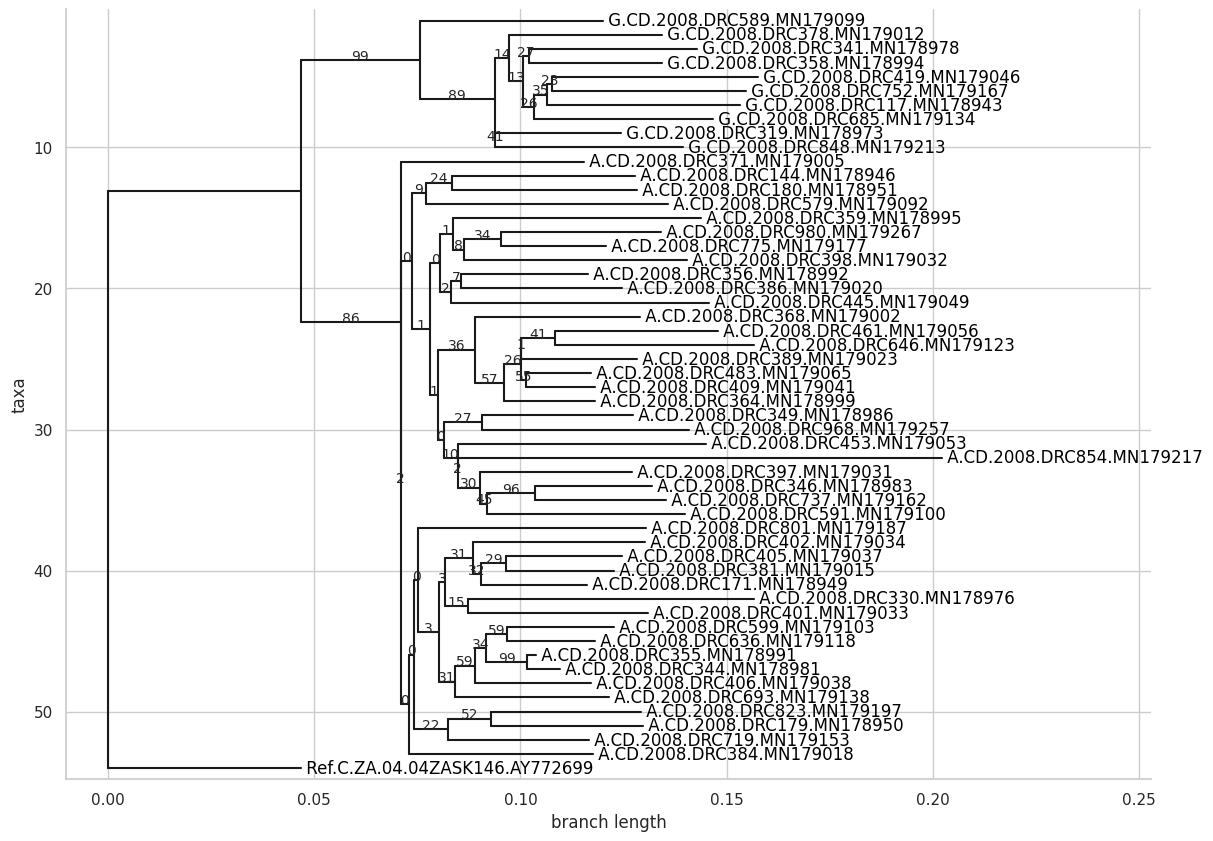

In [66]:
!raxml-ng --bootstrap --msa {filtered_alignment} --model GTR+G --prefix T2 --threads 2 --bs-tree 100 --outgroup {outgroup_label}

!raxml-ng --bsconverge --bs-trees T2.raxml.bootstraps --prefix Test --threads 2 --bs-cutoff 0.03 --outgroup {outgroup_label}

!raxml-ng --support --tree ml_tree.raxml.bestTree --bs-trees T2.raxml.bootstraps --prefix T3 --threads 2 --outgroup {outgroup_label}



In [1]:
# plot the tree with bootstrap support on internal nodes

tree = Phylo.read("T3.raxml.support", "newick")
fig, ax = plt.subplots(figsize=(16, 14))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
Phylo.draw(tree, axes=ax)
plt.show()

NameError: name 'Phylo' is not defined